**Instructions to connect local runtime**

Step 1: Install [Jupyter](https://jupyter.org/install) on your local machine. (one-time)

Step 2: Install and enable the `jupyter_http_over_ws` jupyter extension (one-time)
```
> pip install jupyter_http_over_ws
> jupyter serverextension enable --py jupyter_http_over_ws
```
Step 3: Start server and authenticate
```
> jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
```
Click the "Connect" button and select "Connect to local runtime...". Enter the port from the previous step in the dialog that appears and click the "Connect" button. After this, you should now be connected to your local runtime.



**Libraries**

In [0]:
# Basic libraries
import numpy as np
import pandas as pd

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Modeling
import sklearn.ensemble
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix,roc_curve,auc
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to C:\Users\Nishan
[nltk_data]     Chathuranga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Nishan
[nltk_data]     Chathuranga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Nishan
[nltk_data]     Chathuranga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**Load Data**

In [0]:
# Bot Dataset From - https://www.kaggle.com/c/twitter-bot-classification
url_bot_train = 'https://raw.githubusercontent.com/AsyncWave/Fake-NEWS-and-Automaticity-Detection/master/data/Bot/training_data_2_csv_UTF.csv'
# url_bot_test = 'https://raw.githubusercontent.com/AsyncWave/Fake-NEWS-and-Automaticity-Detection/master/data/Bot/test_data_4_students.csv'

# News Data
url_news_credible = 'https://raw.githubusercontent.com/AsyncWave/Fake-NEWS-and-Automaticity-Detection/master/data/Fake%20News/not_onion.csv'
url_news_not_credible = 'https://raw.githubusercontent.com/AsyncWave/Fake-NEWS-and-Automaticity-Detection/master/data/Fake%20News/the_onion.csv'

df_bot_train = pd.read_csv(url_bot_train)
# df_bot_test = pd.read_csv(url_bot_test,sep='\t', encoding = "ISO-8859-1")
df_news_credible = pd.read_csv(url_news_credible, index_col=0)
df_news_not_credible = pd.read_csv(url_news_not_credible, index_col=0)

# **Fake News (News Credibility)**

In [0]:
df_news_credible.head(5)

,author,domain,num_comments,score,subreddit,timestamp,title
0,drak0bsidian,cnn.com,0,1,nottheonion,1554663925,Suspected rhino poacher is killed by an elepha...
1,somefaces,nypost.com,1,1,nottheonion,1554663648,Taliban commander turns himself in to collect ...
2,Sombez,nytimes.com,1,1,nottheonion,1554663558,Rhino Poacher Killed by Elephant and Eaten by ...
3,Bayou-Maharaja,ktoo.org,0,1,nottheonion,1554662778,Young shoves female reporter on way to Violenc...
4,phantommaster1999,buzz.ie,1,1,nottheonion,1554661988,Poacher hunting rhinos trampled to death by el...


In [0]:
df_news_not_credible.head(5)

,author,domain,num_comments,score,subreddit,timestamp,title
0,Kotaay,google.ca,1,1,TheOnion,1554658622,Jack Nicholson Banned From Sitting Courtside A...
1,DisastrousCandy3,theonion.com,3,1,TheOnion,1554600149,NicoDerm Introduces New Nicotine Eye Patch
2,SlovenianCat,youtu.be,0,1,TheOnion,1554585700,Last Bastion Of U.S. Economy Succumbs To Pancr...
3,MyNameIsGriffon,sports.theonion.com,0,386,TheOnion,1554559311,Tom Izzo Calls 2019 Spartans Best Team He’s Ev...
4,MyNameIsGriffon,theonion.com,0,3,TheOnion,1554501708,House Democrats Formally Request Trump’s Tax R...


**Clean News Data**

In [0]:
def clean_data(dataframe):
    # Drop duplicate rows
    dataframe.drop_duplicates(subset='title', inplace=True)

    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

In [0]:
clean_data(df_news_credible)

New shape: (12086, 7)


,author,domain,num_comments,score,subreddit,timestamp,title
0,drak0bsidian,cnn.com,0,1,nottheonion,1554663925,suspected rhino poacher is killed by an elepha...
1,somefaces,nypost.com,1,1,nottheonion,1554663648,taliban commander turns himself in to collect ...
2,Sombez,nytimes.com,1,1,nottheonion,1554663558,rhino poacher killed by elephant and eaten by ...
3,Bayou-Maharaja,ktoo.org,0,1,nottheonion,1554662778,young shoves female reporter on way to violenc...
4,phantommaster1999,buzz.ie,1,1,nottheonion,1554661988,poacher hunting rhinos trampled to death by el...


In [0]:
clean_data(df_news_not_credible)

New shape: (14189, 7)


,author,domain,num_comments,score,subreddit,timestamp,title
0,Kotaay,google.ca,1,1,TheOnion,1554658622,jack nicholson banned from sitting courtside a...
1,DisastrousCandy3,theonion.com,3,1,TheOnion,1554600149,nicoderm introduces new nicotine eye patch
2,SlovenianCat,youtu.be,0,1,TheOnion,1554585700,last bastion of u s economy succumbs to pancre...
3,MyNameIsGriffon,sports.theonion.com,0,386,TheOnion,1554559311,tom izzo calls spartans best team he s ever t...
4,MyNameIsGriffon,theonion.com,0,3,TheOnion,1554501708,house democrats formally request trump s tax r...


In [0]:
# Combine df_news_not_credible & df_news_credible with only 'subreddit' (target) and 'title' (predictor) columns
df_news = pd.concat([df_news_not_credible[['subreddit', 'title']], df_news_credible[['subreddit', 'title']]], axis=0)

#Reset the index
df_news = df_news.reset_index(drop=True)

# Binarize Target subreddit
df_news["subreddit"] = df_news["subreddit"].map({"nottheonion": 0, "TheOnion": 1})

# Preview head of df to show 'TheOnion' titles appear
df_news.head(2)

,subreddit,title
0,1,jack nicholson banned from sitting courtside a...
1,1,nicoderm introduces new nicotine eye patch


In [0]:
df_news.tail(2)

,subreddit,title
26273,0,farming simulator starts up esports with k pri...
26274,0,mark zuckerberg killed goat with laser gun and...


In [0]:
# Set variables to show TheOnion Titles
mask_on = df_news['subreddit'] == 1
df_news_not_credible_titles = df_news[mask_on]['title']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

news_not_credible_cvec = cv1.fit_transform(df_news_not_credible_titles)

# Convert onion_cvec into a DataFrame
news_not_credible_cvec_df = pd.DataFrame(news_not_credible_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(news_not_credible_cvec_df.shape)

(14189, 11906)


In [0]:
# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

news_not_credible_cvec_bi = cv2.fit_transform(df_news_not_credible_titles)

# Convert onion_cvec into a DataFrame
news_not_credible_cvec_df_bi = pd.DataFrame(news_not_credible_cvec_bi.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Onion Titles cvec
print(news_not_credible_cvec_df_bi.shape)

(14189, 34896)


In [0]:
# Set variables to show NotTheOnion Titles
mask_no = df_news['subreddit'] == 0
df_news_credible_titles = df_news[mask_no]['title']

# Instantiate a CountVectorizer
cv3 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
news_credible_cvec = cv3.fit_transform(df_news_credible_titles)

# Convert onion_cvec into a DataFrame
news_credible_cvec_df = pd.DataFrame(news_credible_cvec.toarray(),
                   columns=cv3.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(news_credible_cvec_df.shape)

(12086, 14451)


In [0]:
# Instantiate a CountVectorizer
cv4 = CountVectorizer(stop_words = 'english' , ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
news_credible_cvec_bi = cv4.fit_transform(df_news_credible_titles)

# Convert onion_cvec into a DataFrame
news_credible_cvec_df_bi = pd.DataFrame(news_credible_cvec_bi.toarray(),
                   columns=cv4.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(news_credible_cvec_df_bi.shape)

(12086, 58973)


In [0]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

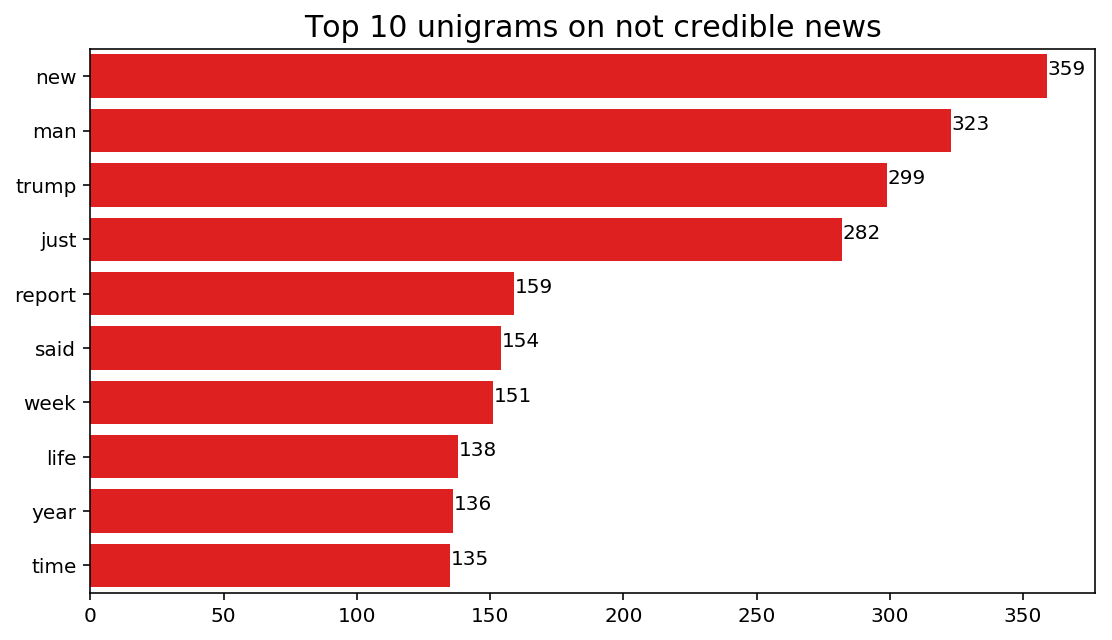

In [0]:
# Set up variables to contain top 10 most used words in Onion
news_not_credible_wc = news_not_credible_cvec_df.sum(axis = 0)
news_not_credible_top_10 = news_not_credible_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(news_not_credible_top_10.values, news_not_credible_top_10.index, 'Top 10 unigrams on not credible news','r') 



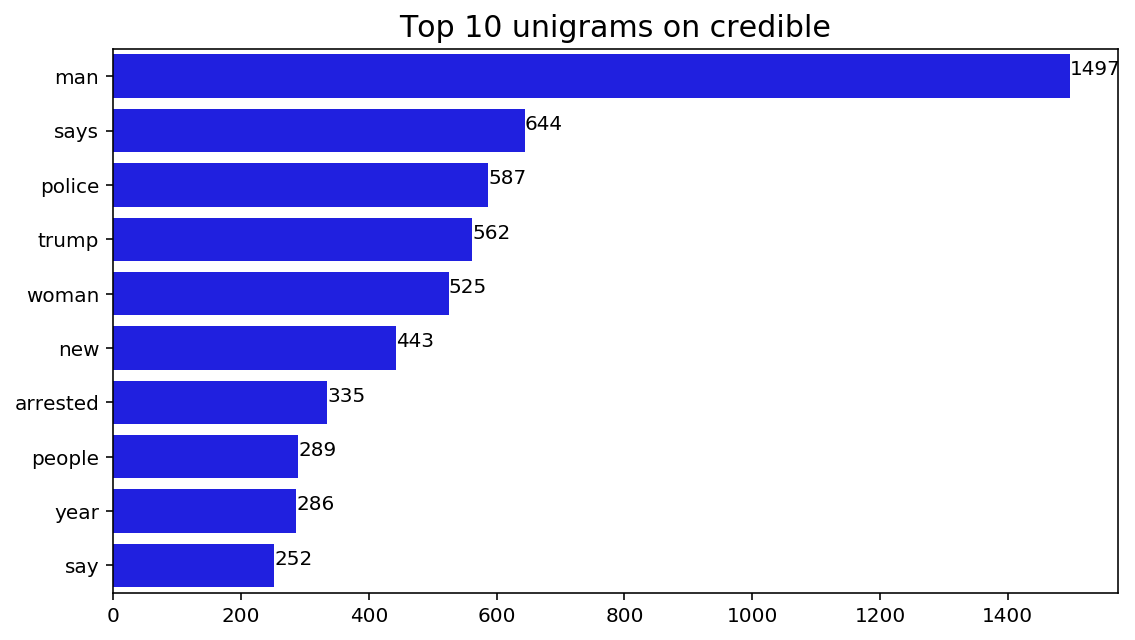

In [0]:
# Set up variables to contain top 10 most used words in Onion
news_credible_wc = news_credible_cvec_df.sum(axis = 0)
news_credible_top_10 = news_credible_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(news_credible_top_10.values, news_credible_top_10.index, 'Top 10 unigrams on credible','b') 

In [0]:
# Create list of unique words in top five
news_credible_10_set = set(news_credible_top_10.index)
news_not_credible_10_set = set(news_not_credible_top_10.index)

# Return common words
common_unigrams = news_not_credible_10_set.intersection(news_credible_10_set)
common_unigrams

{'man', 'new', 'trump', 'year'}

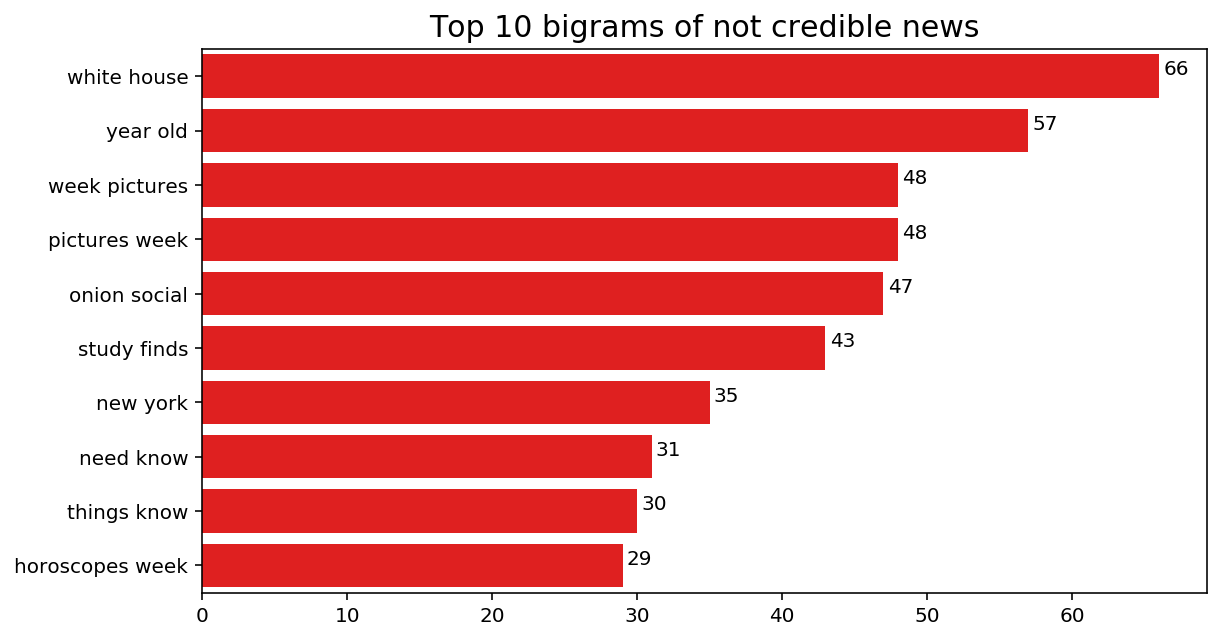

In [0]:
# Set up variables to contain top 10 most used words in Onion
news_not_credible_wc_bi = news_not_credible_cvec_df_bi.sum(axis = 0)
news_not_credible_top_10_bi = news_not_credible_wc_bi.sort_values(ascending=False).head(10)

# Call function
bar_plot(news_not_credible_top_10_bi.values, news_not_credible_top_10_bi.index, 'Top 10 bigrams of not credible news','r') 

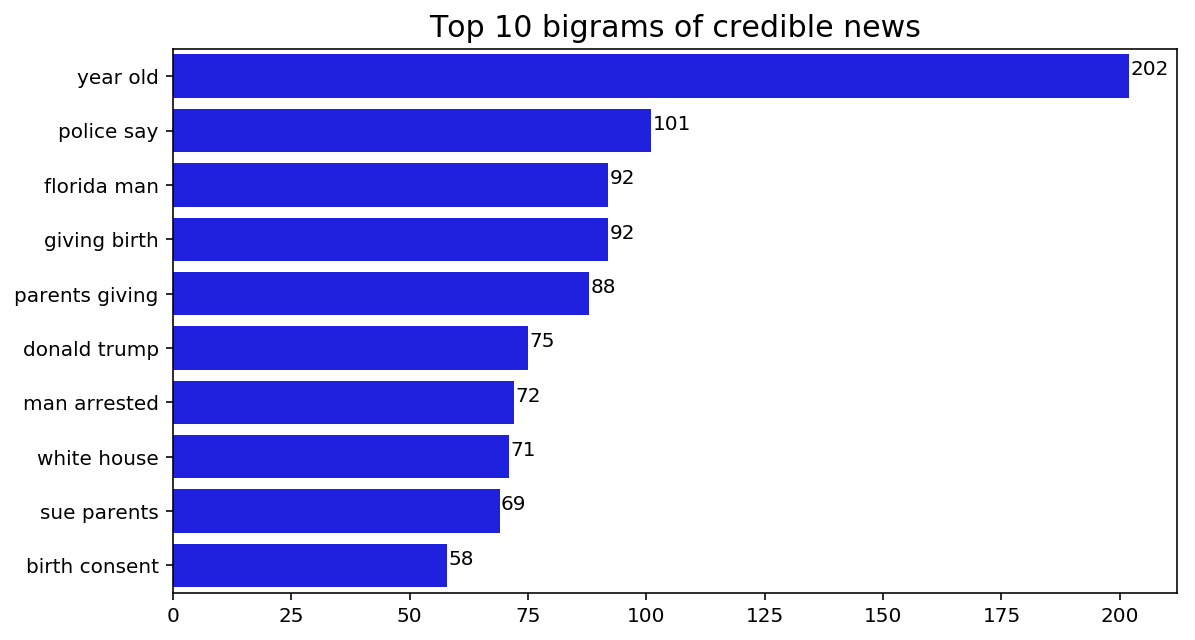

In [0]:
# Set up variables to contain top 10 most used words in Onion
news_credible_wc_bi = news_credible_cvec_df_bi.sum(axis = 0)
news_credible_top_10_bi = news_credible_wc_bi.sort_values(ascending=False).head(10)

# Call function
bar_plot(news_credible_top_10_bi.values, news_credible_top_10_bi.index, 'Top 10 bigrams of credible news','b') 

In [0]:
news_credible_10_list = set(news_credible_top_10_bi.index)
news_not_credible_10_list = set(news_not_credible_top_10_bi.index)

# Return common words
common_bigrams = news_credible_10_list.intersection(news_not_credible_10_list)
common_bigrams

{'white house', 'year old'}

**Create custom stop_words to include common frequent words**

In [0]:
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

In [0]:
# Baseline score
df_news['subreddit'].value_counts(normalize=True)

1    0.540019
0    0.459981
Name: subreddit, dtype: float64

**Set X (predictor) and y (target) variables**

In [0]:
X = df_news['title']
y = df_news['subreddit']

**Train/Test Split**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

**CountVectorizer & MultinomialNB (Best Accuracy Score)**

In [0]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8878514158124429
Train score 0.9970059880239521
Test score 0.8972446338864363


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.36}

**CountVectorizer & MultinomialNB: Best Params**

In [0]:
#Instantiate the classifier and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

0.8972446338864363


**Confusion Matrix**

In [0]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[2701,  321],
       [ 354, 3193]], dtype=int64)

Text(0.5,257.44,'Predicted label')

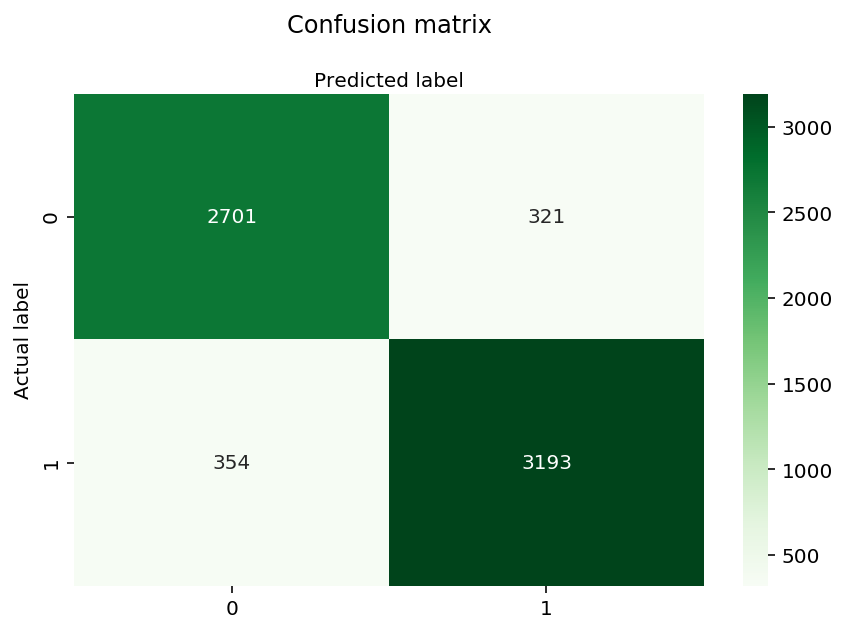

In [0]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greens" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [0]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

**Conclusion 1** - **Accuracy Scores**

In [0]:
# Print Scores 
print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 89.72 %
Precision: 90.87 %
Recall: 90.02 %
Specificity: 89.38 %
Misclassification Rate: 11.11 %


**CountVectorizer & Logistic Regression** : Best Coefficient Interpretability

In [0]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8531411752765655
Train score 0.9618897797625089
Test score 0.8652762977622165


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 1}

In [0]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec2 = CountVectorizer(stop_words = custom)

# Fit and transform the vectorizor
cvec2.fit(X_train)

Xcvec2_train = cvec2.transform(X_train)
Xcvec2_test = cvec2.transform(X_test)

# Fit the classifier
lr.fit(Xcvec2_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec2_test)

print(lr.score(Xcvec2_test, y_test))

0.8526411934845486


**Coefficient Analysis**

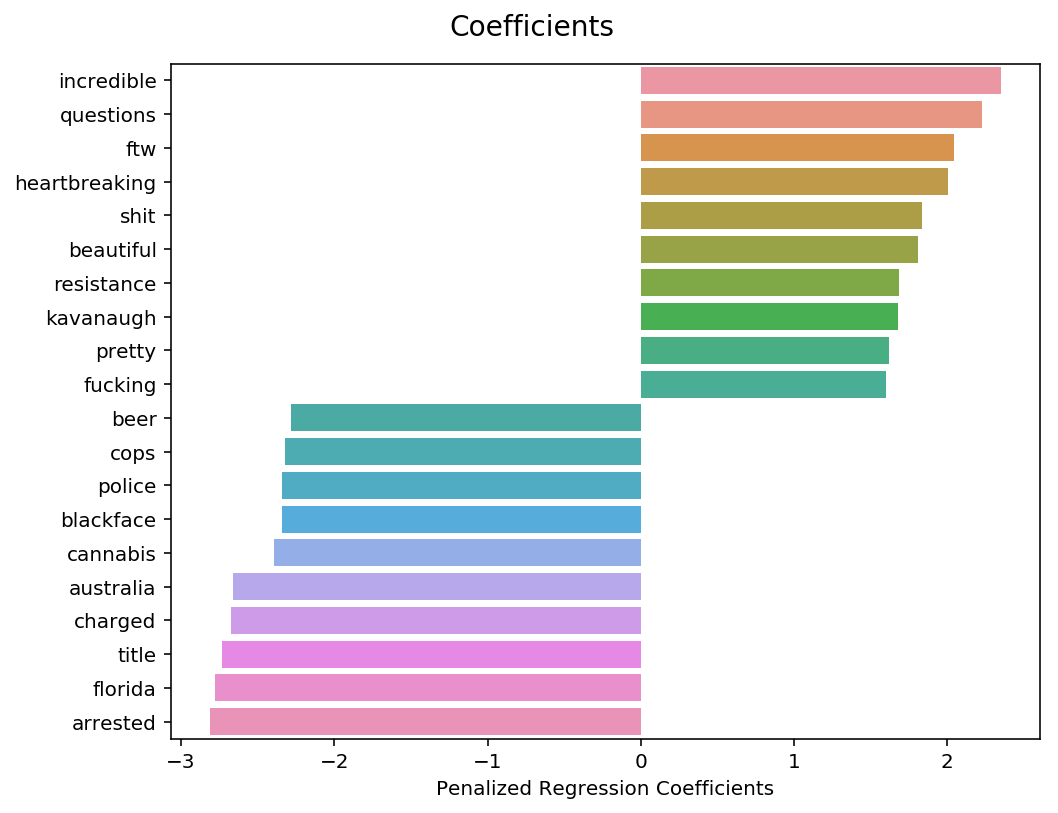

In [0]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec2.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# Jasmine changing things up here on out! Top half not mine. 
# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [0]:
print("The word that contributes the most positively to being from r/TheOnion (Not Credible) is", 
      df_merged.index[0], "followed by", 
      df_merged.index[1], "and",
      df_merged.index[2],".")

print("-----------------------------------")

print("The word that contributes the most positively to being from r/nottheonion (Credible) is", 
      df_merged.index[-1], "followed by", 
      df_merged.index[-2], "and",
      df_merged.index[-3],".")

The word that contributes the most positively to being from r/TheOnion (Not Credible) is incredible followed by questions and ftw .
-----------------------------------
The word that contributes the most positively to being from r/nottheonion (Credible) is arrested followed by florida and title .


In [0]:
# Show coefficients that affect r/TheOnion (Not Credible)
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
incredible,2.350,10.485570
questions,2.225,9.253483
ftw,2.043,7.713716
heartbreaking,2.005,7.426094
shit,1.838,6.283958
beautiful,1.809,6.104340
resistance,1.685,5.392451
kavanaugh,1.676,5.344137
pretty,1.617,5.037954
fucking,1.603,4.967914


**Conclusion 2**

In [0]:
print("As occurences of", df_merged_head.index[0], "increase by 1 in a title, that title is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as r/TheOnion (not credible).")

As occurences of incredible increase by 1 in a title, that title is 10.49 times as likely to be classified as r/TheOnion (not credible).


In [0]:
# Show coefficients that affect r/nottheonion (Credible)
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
arrested,-2.810,16.609918
florida,-2.777,16.070736
title,-2.733,15.378955
charged,-2.675,14.512350
australia,-2.663,14.339242
cannabis,-2.391,10.924413
blackface,-2.342,10.402020
police,-2.341,10.391623
cops,-2.324,10.216459
beer,-2.284,9.815865


**Conclusion 3**

In [0]:
print("As occurences of", df_merged_tail.index[-1], "increase by 1 in a title, that title is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as r/nottheonion.")

As occurences of arrested increase by 1 in a title, that title is 16.61 times as likely to be classified as r/nottheonion.


# **Automaticity Detection**

**Dataset From - https://www.kaggle.com/c/twitter-bot-classification**

In [0]:
df_bot_train.head(5)

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,2/1/2016 7:37,38,False,31,en,NaN,True,False,False,Keri Nelson,1
2,4.303727e+09,4303727112,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,3.063139e+09,3063139353,sc_papers,NaN,NaN,NaN,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,11,745,0,1/1/2015 17:44,146,False,185,en,NaN,False,False,False,lucarivera16,1


In [0]:
training_data = df_bot_train

In [0]:
list(training_data.columns.values)

['id',
 'id_str',
 'screen_name',
 'location',
 'description',
 'url',
 'followers_count',
 'friends_count',
 'listed_count',
 'created_at',
 'favourites_count',
 'verified',
 'statuses_count',
 'lang',
 'status',
 'default_profile',
 'default_profile_image',
 'has_extended_profile',
 'name',
 'bot']

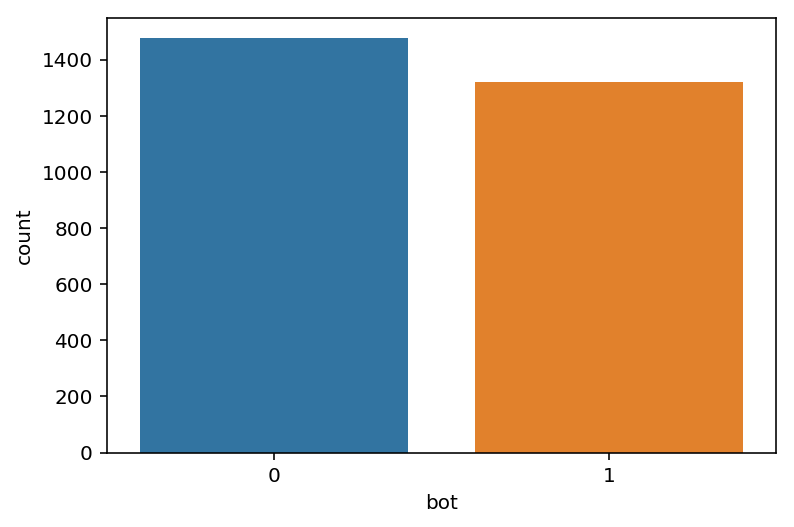

In [0]:
sns.countplot(training_data['bot'])

In [0]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2797 entries, 0 to 2796
Data columns (total 20 columns):
id                       2797 non-null float64
id_str                   2797 non-null object
screen_name              2797 non-null object
location                 1777 non-null object
description              2394 non-null object
url                      1455 non-null object
followers_count          2797 non-null int64
friends_count            2797 non-null int64
listed_count             2797 non-null int64
created_at               2797 non-null object
favourites_count         2797 non-null int64
verified                 2797 non-null bool
statuses_count           2797 non-null int64
lang                     2797 non-null object
status                   2508 non-null object
default_profile          2797 non-null bool
default_profile_image    2797 non-null bool
has_extended_profile     2698 non-null object
name                     2797 non-null object
bot                      2797

In [0]:
training_data.apply(lambda x: sum(x.isnull()))

id                          0
id_str                      0
screen_name                 0
location                 1020
description               403
url                      1342
followers_count             0
friends_count               0
listed_count                0
created_at                  0
favourites_count            0
verified                    0
statuses_count              0
lang                        0
status                    289
default_profile             0
default_profile_image       0
has_extended_profile       99
name                        0
bot                         0
dtype: int64

In [0]:
text_cols=training_data[['screen_name','location','description','url','created_at','lang','status','has_extended_profile','name']]
text_cols.head()

,screen_name,location,description,url,created_at,lang,status,has_extended_profile,name
0,"""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""","""Mon Jan 02 02:25:26 +0000 2017""","""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",False,"""Houston PokŽ Alert"""
1,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,2/1/2016 7:37,en,NaN,False,Keri Nelson
2,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,Fri Nov 20 18:53:22 +0000 2015,en,"{'retweeted': False, 'is_quote_status': False,...",False,Matt Lieber Is Bot
3,sc_papers,NaN,NaN,NaN,2/25/2015 20:11,en,Construction of human anti-tetanus single-chai...,False,single cell papers
4,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,1/1/2015 17:44,en,NaN,False,lucarivera16


In [0]:
text_cols.rename(columns={'screen_name':'screen_name_processed'}, inplace=True)
text_cols.rename(columns={'name':'name_processed'}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [0]:
stop_words = set(stopwords.words('english'))

text_cols['screen_name_processed_num_count'] = ""
for index, row in text_cols.iterrows():
    row['screen_name_processed'] = row['screen_name_processed'].lower() #Convert text to lowercase
    row['screen_name_processed_num_count'] = (sum(c.isdigit() for c in row['screen_name_processed'])) #create new column to get number of numbers
    row['screen_name_processed'] = re.sub(r'\d+','', row['screen_name_processed']) #Remove numbers
    row['screen_name_processed']= row['screen_name_processed'].translate(str.maketrans('','',string.punctuation)) #Remove punctuation
    row['screen_name_processed'] = row['screen_name_processed'].strip() #Remove whitespaces
    row['screen_name_processed'] = [i for i in word_tokenize(row['screen_name_processed']) if not i in stop_words] #Tokenization - REMOVE STOP WORDS
    for word in row['screen_name_processed']:
        row['screen_name_processed'] = lemmatizer.lemmatize(word)
#     for word in  row['screen_name_processed']:
#         row['screen_name_processed'] = (stemmer.stem(word))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
text_cols['name_processed_num_count'] = ""
for index, row in text_cols.iterrows():
    row['name_processed'] = row['name_processed'].lower() #Convert text to lowercase
    row['name_processed_num_count'] = (sum(c.isdigit() for c in row['name_processed'])) #create new column to get number of numbers
    row['name_processed'] = re.sub(r'\d+','', row['name_processed']) #Remove numbers
    row['name_processed']= row['name_processed'].translate(str.maketrans('','',string.punctuation)) #Remove punctuation
    row['name_processed'] = row['name_processed'].strip() #Remove whitespaces
    row['name_processed'] = [i for i in word_tokenize(row['name_processed']) if not i in stop_words] #Tokenization - REMOVE STOP WORDS

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
text_cols.head()

,screen_name_processed,location,description,url,created_at,lang,status,has_extended_profile,name_processed,screen_name_processed_num_count,name_processed_num_count
0,houstonpokemap,"""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""","""Mon Jan 02 02:25:26 +0000 2017""","""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",False,"[houston, pokž, alert]",0,0
1,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,2/1/2016 7:37,en,NaN,False,"[keri, nelson]",0,0
2,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,Fri Nov 20 18:53:22 +0000 2015,en,"{'retweeted': False, 'is_quote_status': False,...",False,"[matt, lieber, bot]",0,0
3,scpapers,NaN,NaN,NaN,2/25/2015 20:11,en,Construction of human anti-tetanus single-chai...,False,"[single, cell, papers]",0,0
4,lucarivera,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,1/1/2015 17:44,en,NaN,False,[lucarivera],2,2


In [0]:
def impute_na(variable):
    for i, row in text_cols[text_cols[variable].isnull()].iterrows():
        obs_sample = text_cols[variable].dropna().sample(1, random_state=int(row.screen_name_processed_num_count))
        obs_sample.index = [i]
        text_cols.at[i, variable] = obs_sample

In [0]:
impute_na('has_extended_profile')

In [0]:
word_list = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|clit|bbb|butt|fuck|XXX|sex|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'
            
text_cols['screen_name_binary'] = training_data.screen_name.str.contains(word_list, case=False, na=False)
text_cols['name_binary'] = training_data.name.str.contains(word_list, case=False, na=False)
text_cols['description_binary'] = training_data.description.str.contains(word_list, case=False, na=False)
text_cols['status_binary'] = training_data.status.str.contains(word_list, case=False, na=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [0]:
text_cols['listed_count_binary'] = (training_data.listed_count>20000)==False

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
for column in training_data:
    text_cols[column+'_NA'] = np.where(training_data[column].isnull(), 1, 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
NA_cols = [col for col in text_cols.columns if 'NA' in col]
NA_cols

['id_NA',
 'id_str_NA',
 'screen_name_NA',
 'location_NA',
 'description_NA',
 'url_NA',
 'followers_count_NA',
 'friends_count_NA',
 'listed_count_NA',
 'created_at_NA',
 'favourites_count_NA',
 'verified_NA',
 'statuses_count_NA',
 'lang_NA',
 'status_NA',
 'default_profile_NA',
 'default_profile_image_NA',
 'has_extended_profile_NA',
 'name_NA',
 'bot_NA']

In [0]:
text_cols.has_extended_profile = text_cols.has_extended_profile.astype(int)

In [0]:
text_cols.rename(columns={'has_extended_profile':'has_extended_profile_processed'}, inplace=True)

In [0]:
text_cols_features = text_cols[['has_extended_profile_processed','name_processed_num_count','screen_name_processed_num_count','screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'listed_count_binary','location_NA','description_NA','url_NA','followers_count_NA','friends_count_NA','listed_count_NA','created_at_NA','favourites_count_NA','verified_NA','statuses_count_NA','lang_NA','status_NA','default_profile_NA','default_profile_image_NA','has_extended_profile_NA','name_NA']].copy()
training_data_features = training_data[['verified', 'followers_count', 'friends_count', 'statuses_count','bot']].copy()

In [0]:
result = pd.concat([text_cols_features, training_data_features], axis=1, sort=False)
result.to_csv('D:/processed.csv', index=False)

In [0]:
mask_on = training_data['bot'] == 1
training_data_bot_description = training_data[mask_on]['description']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
bot_cvec = cv1.fit_transform(training_data_bot_description.values.astype('U'))

# Convert onion_cvec into a DataFrame
bot_cvec_df = pd.DataFrame(bot_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(bot_cvec_df.shape)

(1321, 4638)


In [0]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

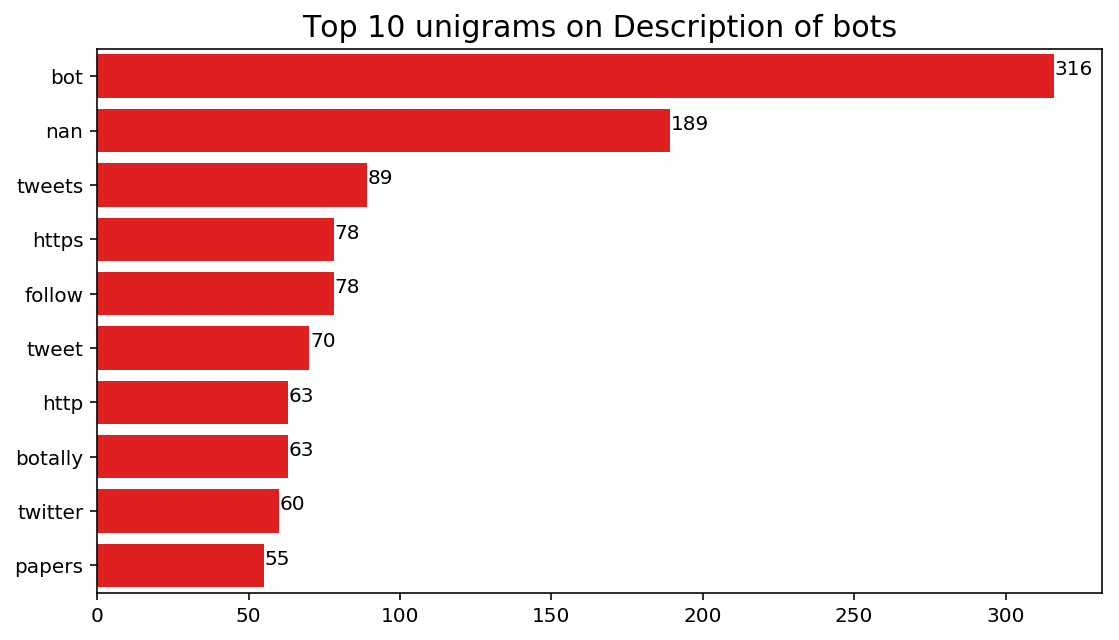

In [0]:
bot_wc = bot_cvec_df.sum(axis = 0)
bot_top_10 = bot_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(bot_top_10.values, bot_top_10.index, 'Top 10 unigrams on Description of bots','r') 

**Modling**

In [0]:
result_no_f = training_data_features
training_result_no_f = result_no_f.drop('bot', axis=1)
X = training_result_no_f.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, result_no_f.bot, test_size=0.3,
                                                    random_state=0)
ovrsmple = SMOTE(ratio='minority')
X_train, y_train = ovrsmple.fit_sample(X_train, y_train)
rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=500,
                                              min_samples_split=5,
                                              criterion='gini', 
                                              max_features='auto',
                                              max_depth = 8,
                                              oob_score=True,
                                              random_state=42,
                                              n_jobs=-1)
rfc.fit(X_train, y_train)

print('Random Forest Classifier Train Accuracy Score :', rfc.score(X_train, y_train))
print('Random Forest Classifier Test Score :', rfc.score(X_test, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest Classifier Train Accuracy Score : 0.9221902017291066
Random Forest Classifier Test Score : 0.8726190476190476


In [0]:
training = result.drop('bot', axis=1)
X = training.as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, result.bot, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1957, 28), (840, 28))

In [0]:
y_train.value_counts()

0    1041
1     916
Name: bot, dtype: int64

In [0]:
y_test.value_counts()

0    435
1    405
Name: bot, dtype: int64

In [0]:
ovrsmple = SMOTE(ratio='minority')

X_train, y_train = ovrsmple.fit_sample(X_train, y_train)

In [0]:
np.bincount(y_train)

array([1041, 1041], dtype=int64)

In [0]:
rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=500,
                                              min_samples_split=5,
                                              criterion='gini', 
                                              max_features='auto',
                                              max_depth = 8,
                                              oob_score=True,
                                              random_state=42,
                                              n_jobs=-1)

In [0]:
rfc.fit(X_train, y_train)

print('Random Forest Classifier Train Accuracy Score :', rfc.score(X_train, y_train))
print('Random Forest Classifier Test Score :', rfc.score(X_test, y_test))

Random Forest Classifier Train Accuracy Score : 0.9250720461095101
Random Forest Classifier Test Score : 0.8845238095238095


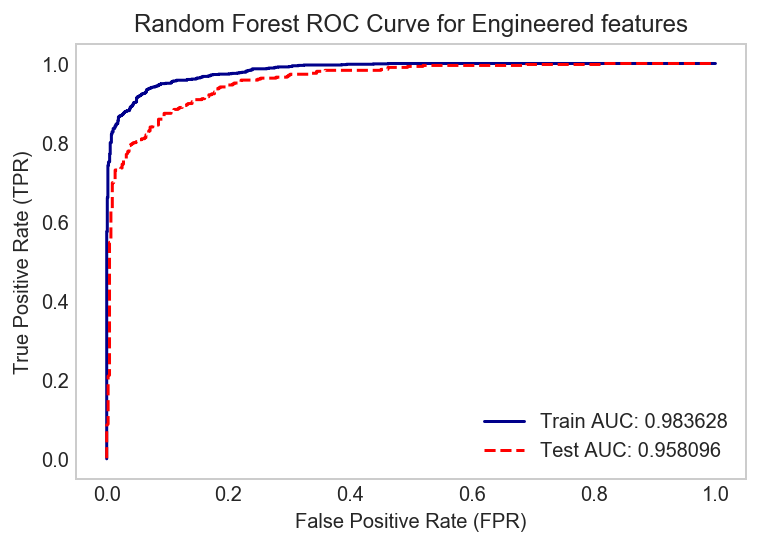

In [0]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rfc.predict_proba(X_train)
scores_test = rfc.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Random Forest ROC Curve for Engineered features")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')